In [1]:
import os

import pandas as pd
import pathlib

from src.churn_prediction_tbauctions.preprocess import load_and_preprocess_data_for_training
from dotenv import load_dotenv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

In [2]:
os.getenv("PREPROCESSED_DATA")

'/home/paolo/git/churn-prediction-tbauctions/data/processed.parquet'

In [4]:
load_dotenv()

data: pd.DataFrame = load_and_preprocess_data_for_training().collect().to_pandas()

{dtype('bool'),
 CategoricalDtype(categories=['male', 'female'], ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['nl', 'fr', 'de', 'pt', 'en', 'pl', 'ro', 'it', 'el', 'hu',
                   'cs', 'es', 'sl', 'sr', 'uk', 'bg', 'mk', 'hr', 'tr', 'sv',
                   'da', 'sk', 'lt', 'ru', 'iw', 'fi', 'lv', 'ar', 'bs', 'et',
                   'eu', 'nb', 'ka', 'ca', 'zh', 'be'],
 , ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['ios', 'unknown', 'android'], ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['nl', 'be', 'fr', 'lu', 'pt', 'bg', 'si', 'pl', 'ro', 'gb',
                   ...
                   'bt', 'er', 'cf', 'sy', 'sd', 'sj', 'nr', 'va', 'mm', 'ss'],
 , ordered=False, categories_dtype=object),
 dtype('float32'),
 dtype('int64'),
 dtype('uint32'),
 dtype('uint8')}

In [4]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import make_column_transformer


def retrieve_categorical_columns_to_encode(dataframe: pd.DataFrame) -> tuple[list[str], list[str]]:
    one_hot_encoded_columns: list[str] = []
    ordinal_encoded_columns: list[str] = []

    for col in dataframe.select_dtypes("category").columns:
        if dataframe[col].nunique() <= 5:
            one_hot_encoded_columns.append(col)
        else:
            ordinal_encoded_columns.append(col)

    return one_hot_encoded_columns, ordinal_encoded_columns


standardized_columns: list[str] = data.select_dtypes(include="number").columns.tolist()
one_hot_encoded_columns, ordinal_encoded_columns = retrieve_categorical_columns_to_encode(data)


column_transformer = make_column_transformer(
    (OneHotEncoder(dtype=np.float32, sparse_output=False, drop="first", handle_unknown="ignore"), one_hot_encoded_columns),
    (OrdinalEncoder(dtype=np.float32, unknown_value=np.nan, handle_unknown="use_encoded_value"), ordinal_encoded_columns),
    (RobustScaler(), standardized_columns),
    remainder="passthrough",
    n_jobs=-1,
    verbose=1,
    verbose_feature_names_out=False
).set_output(transform="pandas")

data_transformed = column_transformer.fit_transform(data)

In [5]:
data_transformed_dropped = data_transformed.drop(columns=[col for col in data_transformed.columns if col.endswith("days") or col.endswith("min") or col.endswith("max")  or col.endswith("median") or col.endswith("sum")])
data_transformed_dropped

,gender_male,mobile_device_ios,mobile_device_unknown,country,preferred_language,ID,num_of_active_weeks,days_subscribed,unique_lots_viewed_average,amount_views_average,bidded_on_amount_lots_average,bids_places_average,total_bidded_average,money_spend_average,amount_lots_won_average,is_company,churned
0,0.0,0.0,0.0,87.0,24.0,-0.5625,0.500000,0.071429,1.354545,2.215278,0.0,0.0,0.0,0.0,0.0,False,False
1,0.0,0.0,1.0,87.0,24.0,-0.1250,5.333333,2.571429,0.102597,-0.108532,0.0,0.0,0.0,0.0,0.0,False,False
2,0.0,0.0,1.0,100.0,7.0,0.7500,2.666667,2.571429,-0.216746,-0.227705,0.0,0.0,0.0,0.0,0.0,True,False
3,1.0,1.0,0.0,87.0,24.0,-0.5000,0.333333,1.500000,5.056364,5.006944,0.0,0.0,0.0,0.0,0.0,False,False
4,1.0,0.0,0.0,87.0,24.0,0.7500,-0.333333,-0.357143,-0.281818,-0.368056,0.0,0.0,0.0,0.0,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680403,0.0,1.0,0.0,87.0,24.0,-0.1875,0.166667,0.142857,-0.354545,-0.284722,0.0,0.0,0.0,0.0,0.0,False,False
680404,0.0,1.0,0.0,87.0,24.0,0.1250,0.000000,0.000000,0.300000,0.770833,0.0,0.0,0.0,0.0,0.0,False,False
680405,1.0,0.0,0.0,87.0,24.0,-0.3750,-0.333333,-0.357143,1.536364,1.298611,0.0,0.0,0.0,0.0,0.0,False,False
680406,0.0,1.0,0.0,87.0,24.0,0.5000,-0.333333,-0.357143,-0.281818,-0.284722,0.0,0.0,0.0,0.0,0.0,True,False


In [10]:
data_transformed_dropped[['churned']].sort_values(by='churned', ascending=False)

,churned
gender_male,-0.000653
mobile_device_ios,-0.001626
mobile_device_unknown,0.001352
country,0.001754
preferred_language,0.001437
ID,-0.000729
num_of_active_weeks,-0.284063
days_subscribed,-0.356223
unique_lots_viewed_average,-0.127503
amount_views_average,-0.080492


Text(0.5, 1.0, 'Features Correlating with Target')

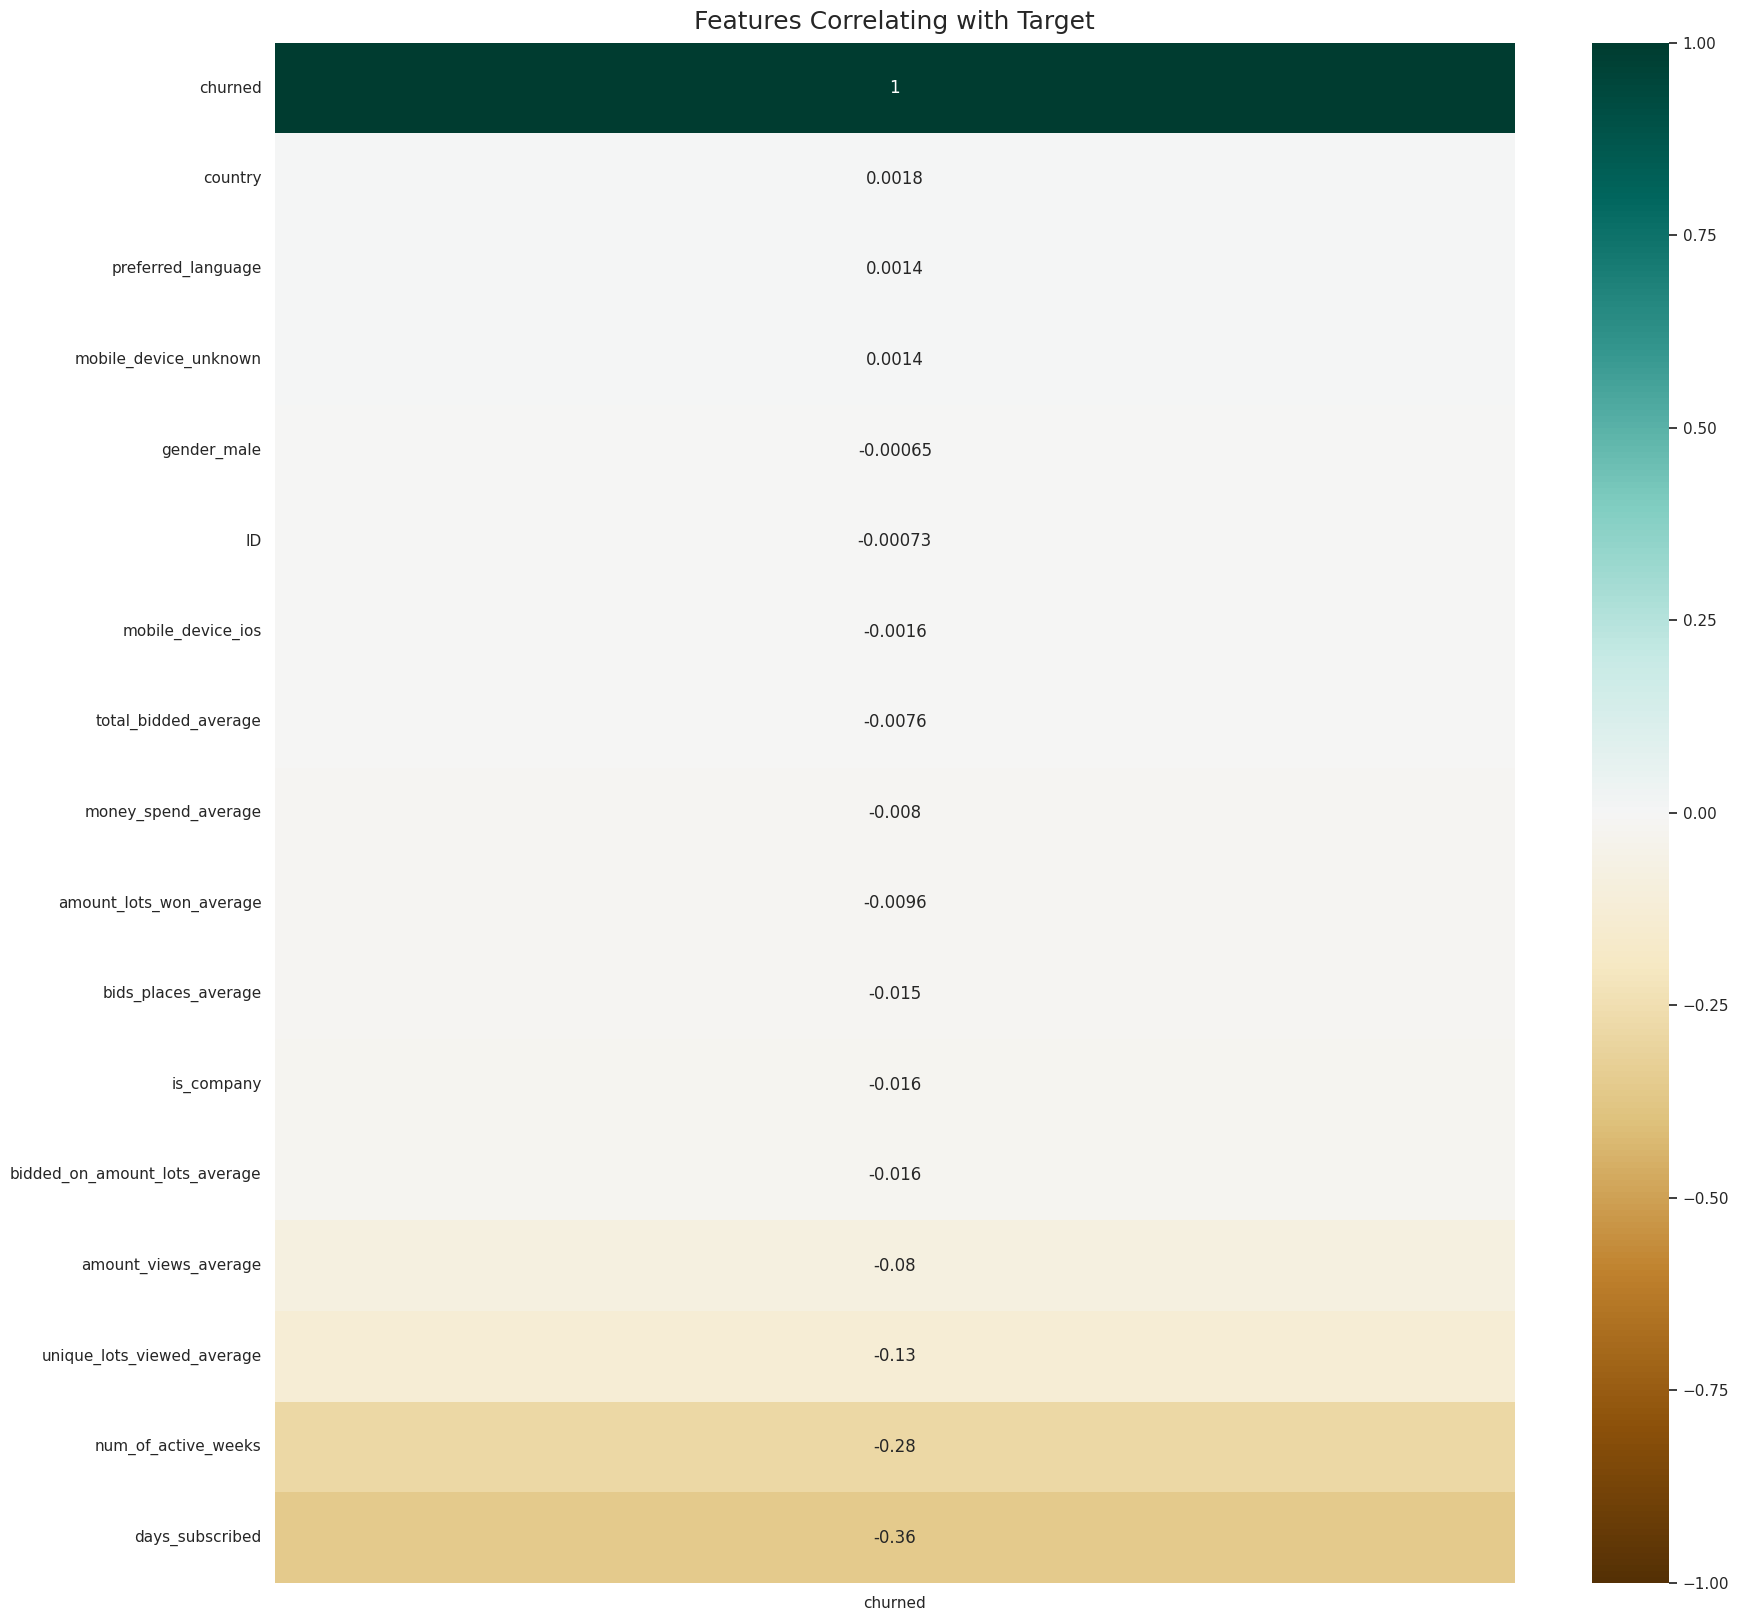

In [11]:
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(corr[['churned']].sort_values(by='churned', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Target', fontdict={'fontsize':18}, pad=10)

<Axes: >

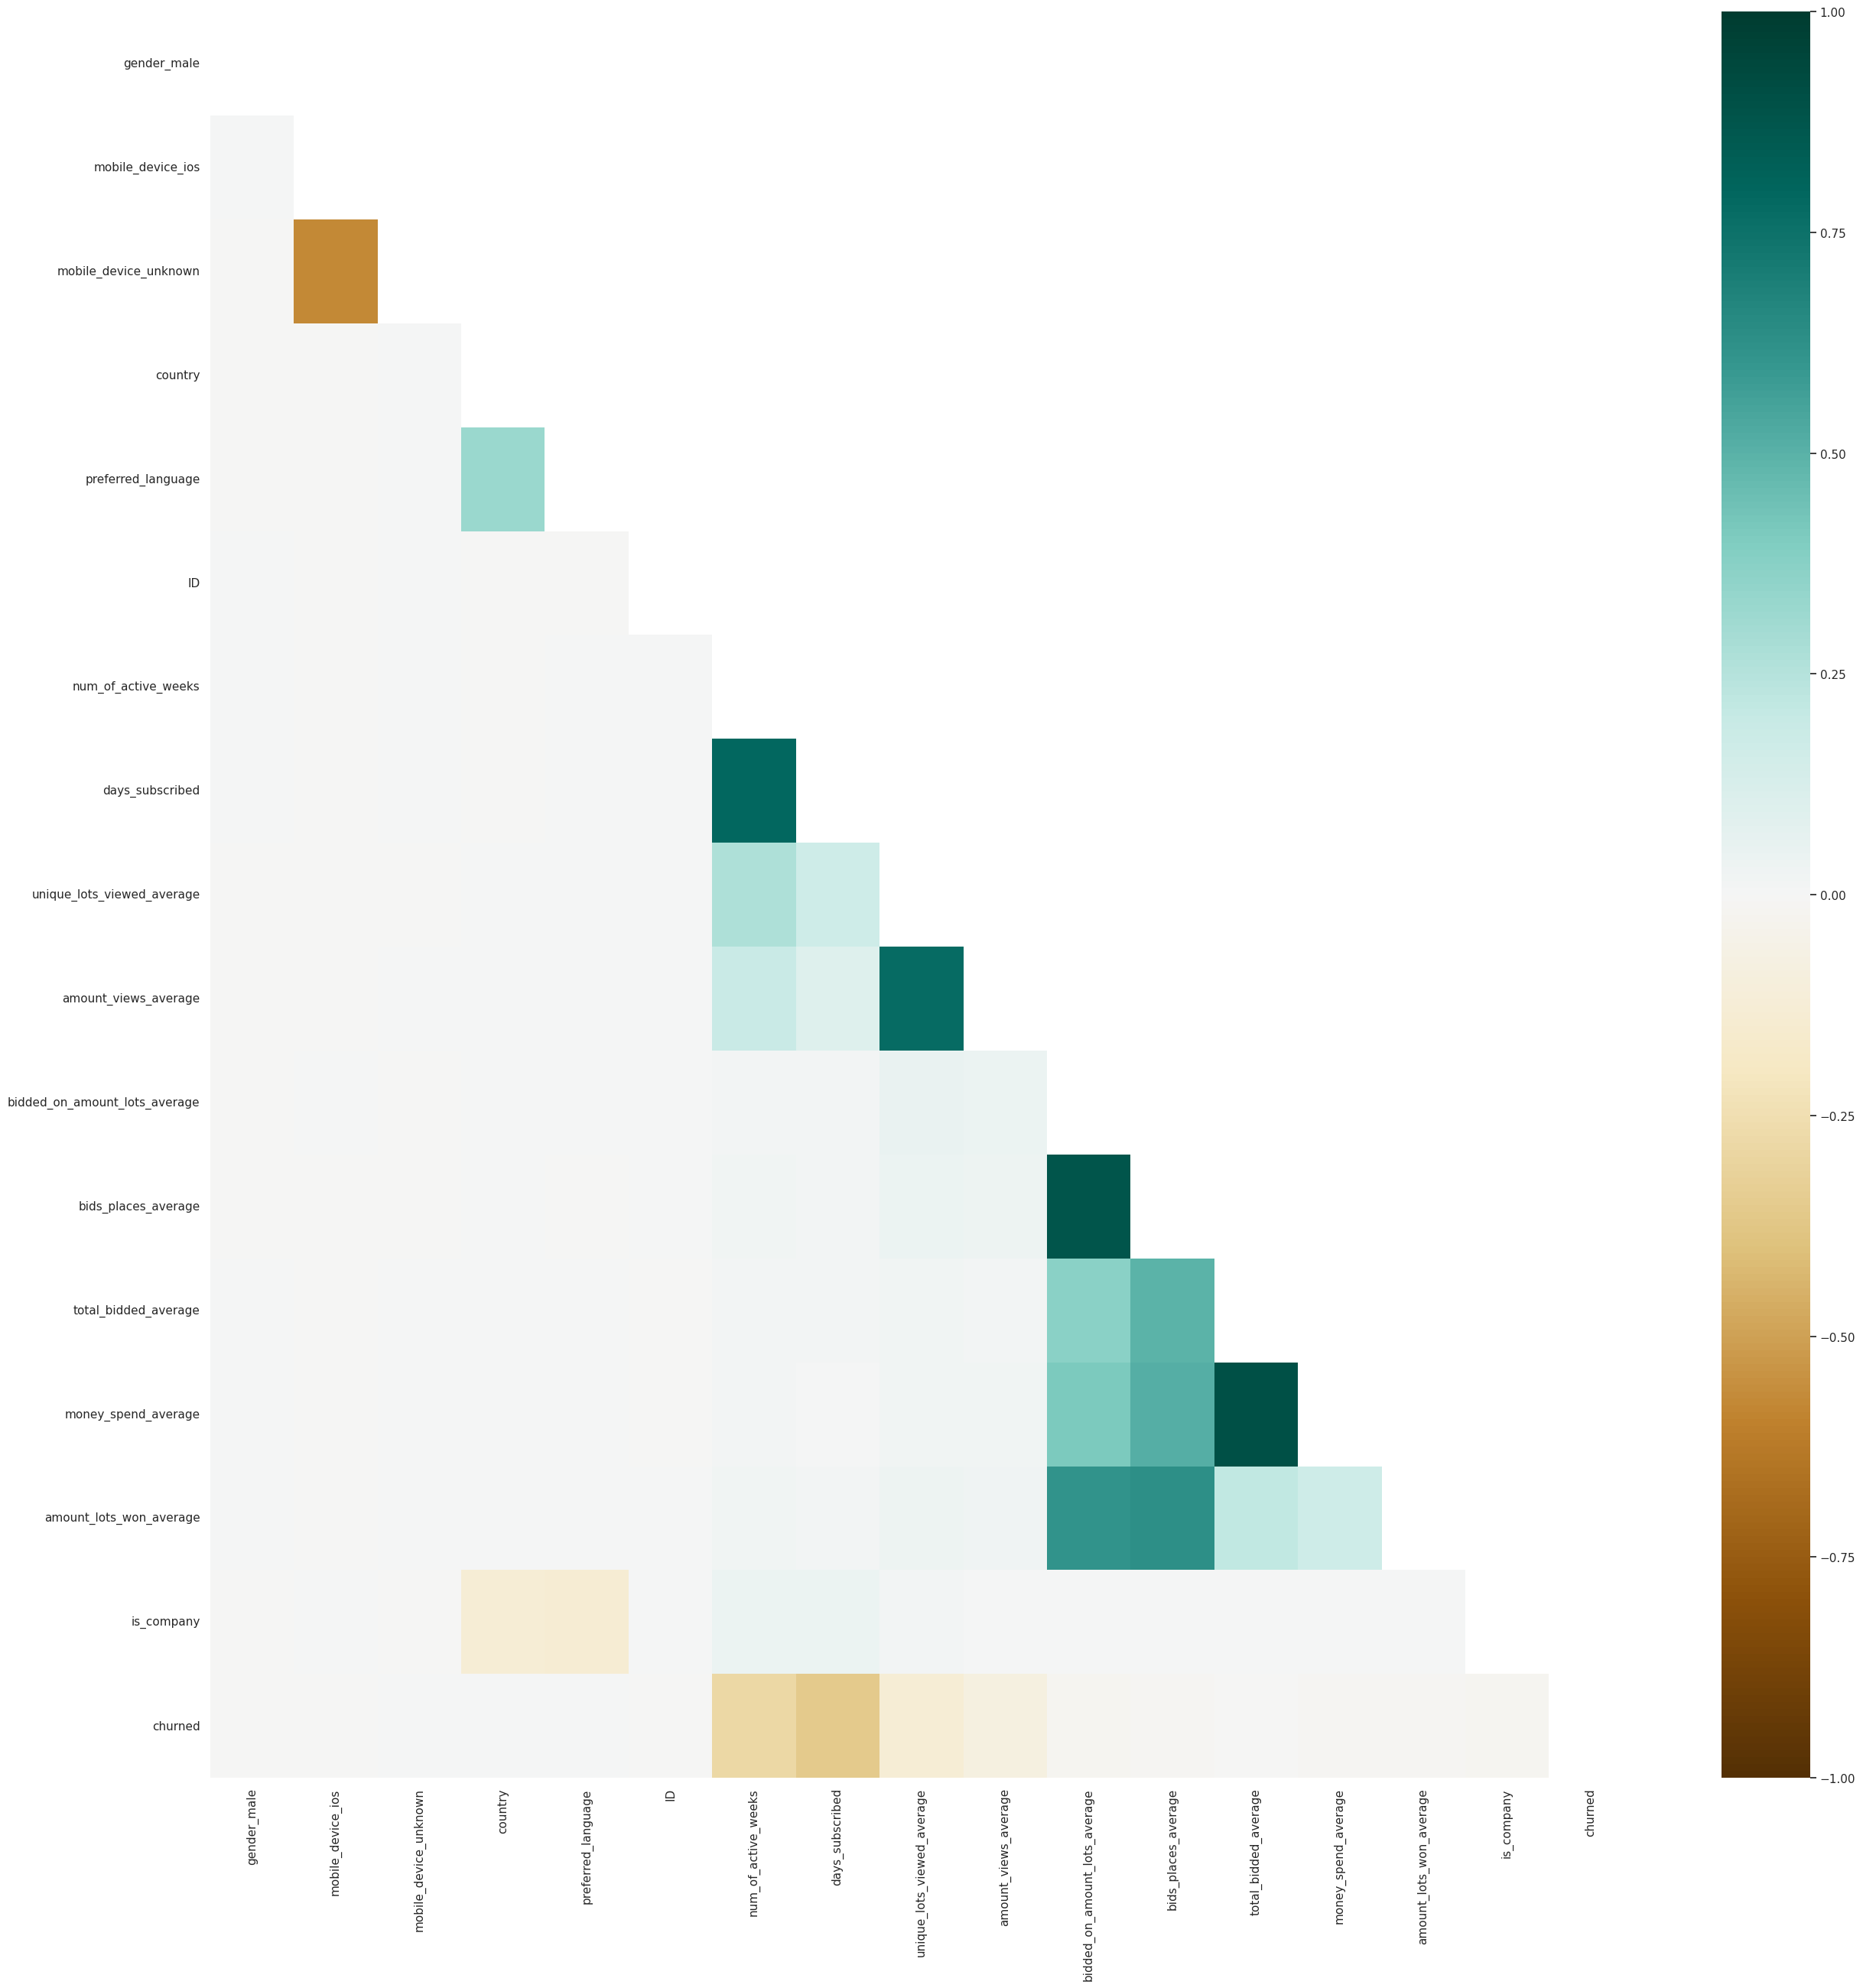

In [7]:
# Compute the correlation matrix
corr = data_transformed_dropped.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
    